# **Kaggle Challenge: Pirate Pain Dataset 🏴‍☠️ (v13: Robust Evaluation)**

This notebook refines the training and evaluation strategy to combat high variance between folds and produce a more reliable performance metric. The core model remains the same, but the validation framework is significantly upgraded.

**Strategy Update:**
1.  **Hold-Out Test Set:** A true 20% hold-out test set is created at the beginning. This data is **never seen** during HPO or training and is used only for a final, unbiased evaluation of the ensemble's generalization performance.
2.  **🔥 Repeated Stratified K-Fold:** To combat the "terrible folds" problem, `StratifiedKFold` is replaced with `RepeatedStratifiedKFold`. We now use 5 splits with 3 repeats, training **15 models in total**. This smooths out variance caused by unlucky data splits, especially important given the small number of 'pirate' samples.
3.  **Final Evaluation Metrics:** A new section has been added to evaluate the full 15-model ensemble on the hold-out test set, generating a final classification report and confusion matrix to precisely measure performance.

## ⚙️ 1. Setup & Libraries

In [63]:
# Set seed for reproducibility
SEED = 1234

# Import necessary libraries
import os
import logging
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import copy
from itertools import product
import time
import gc

# Set environment variables before importing modules
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# --- PyTorch Imports ---
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

# --- Sklearn Imports ---
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Ray[tune] & Optuna Imports ---
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from functools import partial

# --- Setup Directories & Device ---
logs_dir = "tensorboard"
os.makedirs("models", exist_ok=True)
os.makedirs("submissions", exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    print("\n--- Using GPU ---")
else:
    device = torch.device("cpu")
    print("\n--- Using CPU ---")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


--- Using GPU ---
PyTorch version: 2.5.1
Device: cuda


## 🔄 2. Data Loading, Splitting & Feature Engineering

In [64]:
print("--- 1. Loading Data ---")

# --- Define File Paths and Features ---
DATA_DIR = "data"
X_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train.csv")
Y_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train_labels.csv")
X_TEST_PATH = os.path.join(DATA_DIR, "pirate_pain_test.csv")

try:
    features_long_df = pd.read_csv(X_TRAIN_PATH)
    labels_df = pd.read_csv(Y_TRAIN_PATH)
    X_test_long_df = pd.read_csv(X_TEST_PATH)
    
    N_TIMESTEPS = 160
    JOINT_FEATURES = [f"joint_{i:02d}" for i in range(31)]
    PAIN_FEATURES = [f"pain_survey_{i}" for i in range(1, 5)]
    TIME_FEATURE = ['time']
    FEATURES = JOINT_FEATURES + PAIN_FEATURES + TIME_FEATURE
    if 'joint_30' in FEATURES:
        FEATURES.remove('joint_30')
        print("REMOVED 'joint_30' from feature list.")
        
    LABEL_MAPPING = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
    N_CLASSES = len(LABEL_MAPPING)

    def reshape_data(df, features_list, n_timesteps):
        df_pivot = df.pivot(index='sample_index', columns='time', values=features_list)
        data_2d = df_pivot.values
        n_samples = data_2d.shape[0]
        data_3d = data_2d.reshape(n_samples, len(features_list), n_timesteps)
        return data_3d.transpose(0, 2, 1)

    X_train_full_raw = reshape_data(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())], FEATURES, N_TIMESTEPS)
    X_submission_raw = reshape_data(X_test_long_df, FEATURES, N_TIMESTEPS)
    y_train_full_df = labels_df.sort_values(by='sample_index')
    le = LabelEncoder().fit(list(LABEL_MAPPING.keys()))
    y_train_full_raw = le.transform(y_train_full_df['label'])
    print(f"Loaded X_train_full (shape: {X_train_full_raw.shape}) and y_train_full (shape: {y_train_full_raw.shape})")
    print(f"Loaded X_test_full (shape: {X_submission_raw.shape})")

    print("\n--- 2. Engineering 'is_pirate' Feature ---")
    static_cols = ['sample_index', 'n_legs', 'n_hands', 'n_eyes']
    static_df = features_long_df[static_cols].drop_duplicates().set_index('sample_index')
    pirate_filter = (static_df['n_legs'] == 'one+peg_leg') | (static_df['n_hands'] == 'one+hook_hand') | (static_df['n_eyes'] == 'one+eye_patch')
    pirate_indices = static_df[pirate_filter].index
    sample_indices_ordered = sorted(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())]['sample_index'].unique())
    is_pirate_map = np.array([1 if idx in pirate_indices else 0 for idx in sample_indices_ordered])
    pirate_feature_broadcast = np.tile(is_pirate_map.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))
    X_train_full_engineered = np.concatenate([X_train_full_raw, pirate_feature_broadcast], axis=2)

    static_df_test = X_test_long_df[static_cols].drop_duplicates().set_index('sample_index')
    pirate_filter_test = (static_df_test['n_legs'] == 'one+peg_leg') | (static_df_test['n_hands'] == 'one+hook_hand') | (static_df_test['n_eyes'] == 'one+eye_patch')
    pirate_indices_test = static_df_test[pirate_filter_test].index
    sample_indices_test_ordered = sorted(X_test_long_df['sample_index'].unique())
    is_pirate_map_test = np.array([1 if idx in pirate_indices_test else 0 for idx in sample_indices_test_ordered])
    pirate_feature_broadcast_test = np.tile(is_pirate_map_test.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))
    X_submission_engineered = np.concatenate([X_submission_raw, pirate_feature_broadcast_test], axis=2)
    
    N_FEATURES_NEW = X_train_full_engineered.shape[2]
    print(f"Created X_train_full_engineered (shape: {X_train_full_engineered.shape})")
    print(f"Created X_test_full_engineered (shape: {X_submission_engineered.shape})")
    print(f"N_FEATURES is now: {N_FEATURES_NEW}")

    print("\n--- 3. Calculating Alpha Weights for Focal Loss ---")
    class_counts_series = labels_df['label'].value_counts()
    counts_ordered = class_counts_series.reindex(LABEL_MAPPING.keys()).values
    class_weights_tensor = 1.0 / torch.tensor(counts_ordered, dtype=torch.float)
    alpha_tensor = (class_weights_tensor / class_weights_tensor.sum()).to(device)
    print(f"Class counts (0, 1, 2): {counts_ordered}")
    print(f"Calculated alpha weights: {alpha_tensor}")

    # --- 4. Creating a HIGH-QUALITY 10% Hold-Out Test Set via Grouped Stratification ---
    print("\n--- 4. Creating High-Quality Hold-Out Test Set via Grouped Stratification ---")

    # Create a new, more robust composite column for stratification.
    # If a sample is a pirate, its key is just 'pirate'.
    # Otherwise, its key is its pain label (0, 1, or 2).
    # This ensures the small pirate class is grouped together and can be split correctly.
    stratify_col_grouped = [f"pirate" if pirate == 1 else f"label_{label}" 
                            for label, pirate in zip(y_train_full_raw, is_pirate_map)]

    # Now, create the split using this new, more robust key
    sss_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED) # Using 10%

    # The split is performed on a dummy X, but uses the stratify_col_grouped to generate indices
    train_indices, test_indices = next(sss_test_split.split(X_train_full_engineered, stratify_col_grouped))

    # This is the main training data for HPO and K-Fold
    X_train = X_train_full_engineered[train_indices]
    y_train = y_train_full_raw[train_indices]

    # This is the final, unseen, and now highly representative test set
    X_test = X_train_full_engineered[test_indices]
    y_test = y_train_full_raw[test_indices]

    print(f"Data split successfully.")
    print(f"  Training set size:      {len(X_train)} (More data for training!)")
    print(f"  Hold-out test set size: {len(X_test)}")

    # Optional: Verify the stratification worked
    print("\n--- Verifying Stratification ---")
    original_dist = pd.Series(stratify_col_grouped).value_counts(normalize=True).sort_index()
    test_dist = pd.Series([stratify_col_grouped[i] for i in test_indices]).value_counts(normalize=True).sort_index()
    print("Original Distribution:\n", original_dist)
    print("\nTest Set Distribution:\n", test_dist)

except Exception as e:
    print(f"An error occurred: {e}")

--- 1. Loading Data ---
REMOVED 'joint_30' from feature list.
Loaded X_train_full (shape: (661, 160, 35)) and y_train_full (shape: (661,))
Loaded X_test_full (shape: (1324, 160, 35))

--- 2. Engineering 'is_pirate' Feature ---
Created X_train_full_engineered (shape: (661, 160, 36))
Created X_test_full_engineered (shape: (1324, 160, 36))
N_FEATURES is now: 36

--- 3. Calculating Alpha Weights for Focal Loss ---
Class counts (0, 1, 2): [511  94  56]
Calculated alpha weights: tensor([0.0643, 0.3493, 0.5864], device='cuda:0')

--- 4. Creating High-Quality Hold-Out Test Set via Grouped Stratification ---
Data split successfully.
  Training set size:      594 (More data for training!)
  Hold-out test set size: 67

--- Verifying Stratification ---
Original Distribution:
 label_0    0.084720
label_1    0.140696
label_2    0.765507
pirate     0.009077
Name: proportion, dtype: float64

Test Set Distribution:
 label_0    0.089552
label_1    0.134328
label_2    0.761194
pirate     0.014925
Name: p

## 🛠️ 3. Helper Functions & Custom Loss

In [65]:
class FocalLoss(nn.Module):
    """Implements Focal Loss for cost-sensitive learning."""
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha[targets].to(focal_loss.device)
            focal_loss = alpha_t * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def create_sliding_windows(X_3d, y=None, window_size=100, stride=20):
    new_X, new_y, window_indices = [], [], []
    n_samples, n_timesteps, _ = X_3d.shape
    for i in range(n_samples):
        idx = 0
        while (idx + window_size) <= n_timesteps:
            new_X.append(X_3d[i, idx:idx+window_size, :])
            window_indices.append(i)
            if y is not None: new_y.append(y[i])
            idx += stride
    if y is not None:
        return np.array(new_X), np.array(new_y), np.array(window_indices)
    return np.array(new_X), np.array(window_indices)

def make_loader(ds, batch_size, shuffle, drop_last):
    return DataLoader(ds, batch_size=int(batch_size), shuffle=shuffle, drop_last=drop_last, 
                      num_workers=2, pin_memory=True, persistent_workers=True)

## 🧠 4. Model & Training Engine

In [66]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, rnn_outputs):
        energy = torch.tanh(self.attn(rnn_outputs))
        attn_scores = self.v(energy).squeeze(2)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context_vector = torch.bmm(attn_weights.unsqueeze(1), rnn_outputs).squeeze(1)
        return context_vector

class RecurrentClassifier(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes,
                 conv_out_channels, conv_kernel_size, bidirectional,
                 dropout_rate, feature_dropout_rate, rnn_type='GRU'):
        super().__init__()
        self.rnn_type, self.num_layers, self.hidden_size, self.bidirectional = \
            rnn_type, num_layers, hidden_size, bidirectional
        
        rnn_hidden_dim = hidden_size * 2 if bidirectional else hidden_size

        self.pain_embed_dim, self.pirate_embed_dim = 4, 4
        self.pain_embeddings = nn.ModuleList([nn.Embedding(3, self.pain_embed_dim) for _ in range(4)])
        self.pirate_embedding = nn.Embedding(2, self.pirate_embed_dim)
        
        # --- BUG FIX: Correct number of continuous features ---
        num_continuous_features = 31 # 30 joints + 1 time
        total_embedding_dim = (4 * self.pain_embed_dim) + self.pirate_embed_dim
        conv_input_size = num_continuous_features + total_embedding_dim

        self.conv1d = nn.Conv1d(in_channels=conv_input_size, out_channels=conv_out_channels,
                                kernel_size=conv_kernel_size, padding='same')
        self.conv_activation = nn.ReLU()
        self.feature_dropout = nn.Dropout(feature_dropout_rate)

        if rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=conv_out_channels, hidden_size=hidden_size,
                num_layers=num_layers, batch_first=True, bidirectional=bidirectional,
                dropout=dropout_rate if num_layers > 1 else 0)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=conv_out_channels, hidden_size=hidden_size,
                num_layers=num_layers, batch_first=True, bidirectional=bidirectional,
                dropout=dropout_rate if num_layers > 1 else 0)
        
        self.attention = Attention(rnn_hidden_dim)
        self.classifier = nn.Linear(rnn_hidden_dim, num_classes)

    def forward(self, x):
        # --- BUG FIX: Correct slicing for 31 continuous features ---
        x_continuous = x[:, :, :31]
        x_categorical = x[:, :, 31:].long()
        
        embedded_cats = [self.pain_embeddings[i](x_categorical[:, :, i]) for i in range(4)] \
                      + [self.pirate_embedding(x_categorical[:, :, 4])]
        x_combined = torch.cat([x_continuous] + embedded_cats, dim=2)
        x_permuted = x_combined.permute(0, 2, 1)
        x_conv = self.conv_activation(self.conv1d(x_permuted))
        x_conv_permuted = x_conv.permute(0, 2, 1)
        x_dropped = self.feature_dropout(x_conv_permuted)
        rnn_outputs, _ = self.rnn(x_dropped)
        context_vector = self.attention(rnn_outputs)
        return self.classifier(context_vector)

def train_one_epoch(model, loader, criterion, optimizer, scaler, scheduler, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item() * x.size(0)
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_targets.append(y.cpu().numpy())
    return total_loss / len(loader.dataset.tensors[0]), f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, all_preds, all_targets = 0, [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x)
                loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            all_preds.append(logits.argmax(dim=1).cpu().numpy())
            all_targets.append(y.cpu().numpy())
    return total_loss / len(loader.dataset.tensors[0]), f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')

def objective_function(config, X_train_w, y_train_w, X_val_w, y_val_w, alpha_tensor):
    EPOCHS = 150
    train_loader = make_loader(TensorDataset(X_train_w, y_train_w), config["batch_size"], True, True)
    val_loader = make_loader(TensorDataset(X_val_w, y_val_w), config["batch_size"], False, False)

    model_config = {k: v for k, v in config.items() if k not in ['lr', 'batch_size', 'l2_lambda', 'focal_loss_gamma']}
    model = RecurrentClassifier(**model_config, num_classes=N_CLASSES).to(device)
    model = torch.compile(model, backend="eager")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["l2_lambda"])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=config["lr"], epochs=EPOCHS, steps_per_epoch=len(train_loader)
    )
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    criterion = FocalLoss(alpha=alpha_tensor, gamma=config['focal_loss_gamma'])

    best_val_f1 = -1.0; patience_counter = 0; hpo_patience = 30
    
    for epoch in range(1, EPOCHS + 1):
        train_loss, _ = train_one_epoch(model, train_loader, criterion, optimizer, scaler, scheduler, device)
        _, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
        tune.report({"val_f1": val_f1, "train_loss": train_loss})
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1; patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= hpo_patience: break

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, scaler, device, patience, experiment_name):
    model_path = f"models/{experiment_name}_best_model.pt"
    best_f1 = -1; patience_counter = 0
    print(f"--- Starting Training: {experiment_name} ---")
    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, scheduler, device)
        val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

        if val_f1 > best_f1:
            best_f1, patience_counter = val_f1, 0
            torch.save(model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience: print(f"Early stopping at epoch {epoch}. Best F1: {best_f1:.4f}"); break
        if epoch % 3 == 0: print(f"Epoch {epoch:3d}/{epochs} | Best Val F1: {best_f1:.4f} | Current Val F1: {val_f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    print(f"--- Finished Training --- Best F1: {best_f1:.4f}")
    uncompiled_model = model._orig_mod if hasattr(model, '_orig_mod') else model
    uncompiled_model.load_state_dict(torch.load(model_path))
    return uncompiled_model

## 🧪 5. Phase 1: Hyperparameter Search

In [67]:
print("--- Preparing data for HPO ---")

# Import the new scaler
from sklearn.preprocessing import MinMaxScaler

WINDOW_SIZE = 10
STRIDE = 2

# --- 1. Define feature indices for dual scaling ---
# Original indices (before reordering) of the "spiky" joints [13-25]
spiky_indices_orig = list(range(13, 26)) 
# Original indices of "normal" continuous features (joints 0-12, 26-29, and time=34)
normal_indices_orig = list(range(13)) + list(range(26, 30)) + [34] 
# Original indices of categorical features
categorical_indices_orig = list(range(30, 34)) + [35]

# --- 2. Define reordered indices ---
# This list defines the NEW order of continuous features (normal first, then spiky)
continuous_indices_orig_all = normal_indices_orig + spiky_indices_orig

# Create a mapping from the original index to the new reordered index (0-30)
reordered_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(continuous_indices_orig_all)}

# Get the new locations (in the 0-30 range) for each feature group
normal_indices_reordered = [reordered_mapping[i] for i in normal_indices_orig]
spiky_indices_reordered = [reordered_mapping[i] for i in spiky_indices_orig]
# Note: Categorical features will be at 31-35 after concatenation

# --- 3. Reorder data based on the new 'all' list ---
X_train_reordered = np.concatenate([
    X_train[:, :, continuous_indices_orig_all],
    X_train[:, :, categorical_indices_orig]
], axis=2)

print("--- Creating internal HPO split from main training set ---")
sss_hpo = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
hpo_train_idx, hpo_val_idx = next(sss_hpo.split(X_train_reordered, y_train))
X_train_hpo, y_train_hpo = X_train_reordered[hpo_train_idx], y_train[hpo_train_idx]
X_val_hpo, y_val_hpo = X_train_reordered[hpo_val_idx], y_train[hpo_val_idx]

print("--- Pre-scaling HPO data for efficiency (with dual-scaling) ---")
# --- 4. Define the CORRECTED ColumnTransformer ---
preprocessor_hpo = ColumnTransformer(
    [
        ('normal_scaler', StandardScaler(), normal_indices_reordered),
        ('spiky_scaler', MinMaxScaler(), spiky_indices_reordered) 
    ], 
    remainder='passthrough' # Passes categorical features (31-35) untouched
)

ns, ts, f = X_train_hpo.shape
X_train_hpo_scaled = preprocessor_hpo.fit_transform(X_train_hpo.reshape(ns*ts, f)).reshape(ns, ts, f)
ns_val, ts_val, f_val = X_val_hpo.shape
X_val_hpo_scaled = preprocessor_hpo.transform(X_val_hpo.reshape(ns_val*ts_val, f_val)).reshape(ns_val, ts_val, f_val)

print("--- Pre-creating fixed sliding windows for HPO ---")
X_train_w, y_train_w, _ = create_sliding_windows(X_train_hpo_scaled, y_train_hpo, WINDOW_SIZE, STRIDE)
X_val_w, y_val_w, _ = create_sliding_windows(X_val_hpo_scaled, y_val_hpo, WINDOW_SIZE, STRIDE)

X_train_w_torch = torch.from_numpy(X_train_w).float()
y_train_w_torch = torch.from_numpy(y_train_w).long()
X_val_w_torch = torch.from_numpy(X_val_w).float()
y_val_w_torch = torch.from_numpy(y_val_w).long()

print(f"Created training windows of shape: {X_train_w_torch.shape}")

del X_train_hpo_scaled, X_val_hpo_scaled, X_train_w, y_train_w, X_val_w, y_val_w
gc.collect()

--- Preparing data for HPO ---
--- Creating internal HPO split from main training set ---
--- Pre-scaling HPO data for efficiency (with dual-scaling) ---
--- Pre-creating fixed sliding windows for HPO ---
Created training windows of shape: torch.Size([36100, 10, 36])


1250

In [18]:
search_space = {
    "rnn_type": tune.choice(['GRU', 'LSTM']),
    "focal_loss_gamma": tune.uniform(0.5, 3.0),
    "lr": tune.loguniform(1e-5, 5e-3),
    "batch_size": tune.choice([64, 128]),
    "hidden_size": tune.choice([256, 384, 512]), 
    "num_layers": tune.choice([2, 3]),
    "dropout_rate": tune.uniform(0.1, 0.5), 
    "feature_dropout_rate": tune.uniform(0.1, 0.5),
    "bidirectional": tune.choice([False]), 
    "l2_lambda": tune.loguniform(1e-7, 1e-4),
    "conv_out_channels": tune.choice([128]), 
    "conv_kernel_size": tune.choice([5])
}

def short_trial_name(trial): return f"{trial.trainable_name}_{trial.trial_id}"

if ray.is_initialized(): ray.shutdown()
ray.init(num_cpus=os.cpu_count(), num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

print("--- Starting HPO with Focal Loss and RNN-Type search ---")
analysis = tune.run(
    tune.with_parameters(objective_function, 
                         X_train_w=X_train_w_torch, y_train_w=y_train_w_torch,
                         X_val_w=X_val_w_torch, y_val_w=y_val_w_torch,
                         alpha_tensor=alpha_tensor),
    resources_per_trial={"cpu": 4, "gpu": 0.25},
    config=search_space, 
    num_samples=30, 
    search_alg=OptunaSearch(metric="val_f1", mode="max"),
    scheduler=ASHAScheduler(metric="val_f1", mode="max", grace_period=25, reduction_factor=2),
    name="pirate_pain_robust_search_v13", 
    verbose=1,
    trial_dirname_creator=short_trial_name
)

print("\n--- Search Complete ---\n")
best_trial = analysis.get_best_trial(metric="val_f1", mode="max", scope="all")

if best_trial:
    FINAL_CONFIG = best_trial.config
    FINAL_BEST_VAL_F1 = best_trial.last_result.get("val_f1", 0.0) 
    print(f"Best validation F1 score from HPO: {FINAL_BEST_VAL_F1:.4f}")
    print("Best hyperparameters found:")
    print(FINAL_CONFIG)
else:
    print("ERROR: No trials completed successfully. Using a default config.")
    FINAL_CONFIG = {'rnn_type': 'GRU', 'focal_loss_gamma': 2.0, 'lr': 0.001, 'batch_size': 128, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.3, 'feature_dropout_rate': 0.3, 'bidirectional': True, 'l2_lambda': 1e-06, 'conv_out_channels': 128, 'conv_kernel_size': 5}
    FINAL_BEST_VAL_F1 = 0.0

FINAL_CONFIG['window_size'] = WINDOW_SIZE
FINAL_CONFIG['stride'] = STRIDE

del X_train_w_torch, y_train_w_torch, X_val_w_torch, y_val_w_torch, X_train_hpo, y_train_hpo, X_val_hpo, y_val_hpo
gc.collect()

2025-11-16 13:16:20,237	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_function_e95a3e0e
Traceback (most recent call last):
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
  File "e:\miniconda3\envs\an2dl-kaggle\lib\site-packages\ray\_private\worker.py", line 1028, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpectedly before finishing this task.
	class_name: wrap_functi

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. Lease ID: 070000009ca2d642ed054d76eb9cd5a4b62372639736579b22241931be239f5e Worker ID: fe4ee07d77610c07abf648aa279af55d0738758663246dbd58e323d2 Node ID: 282eac2b05794fa15b5a8bc9f57166a98b0e3ea68ebce9d1e659367b Worker IP address: 127.0.0.1 Worker port: 57865 Worker PID: 8500 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 10054. An existing connection was forcibly closed by the remote host. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


2025-11-16 14:18:00,264	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Karim Negm/ray_results/pirate_pain_robust_search_v13' in 0.0430s.


TuneError: ('Trials did not complete', [objective_function_e95a3e0e])

## 🏆 6. Phase 2: Repeated K-Fold Ensemble Training

In [19]:
print("--- 🏆 Final Configuration Set --- ")
print(f"Best Val F1 from HPO search: {FINAL_BEST_VAL_F1:.4f}")
print(FINAL_CONFIG)

# --- MODIFIED: Use repeats for a more robust ensemble ---
N_SPLITS = 5
N_REPEATS = 3
TOTAL_FOLDS = N_SPLITS * N_REPEATS

FINAL_EXPERIMENT_NAME = f"Robust-{FINAL_CONFIG['rnn_type']}_H{FINAL_CONFIG['hidden_size']}_L{FINAL_CONFIG['num_layers']}_v13"
submission_filename_base = f"submission_{FINAL_EXPERIMENT_NAME}.csv"
print(f"Submission name will be: {submission_filename_base}")

--- 🏆 Final Configuration Set --- 
Best Val F1 from HPO search: 0.9234
{'rnn_type': 'LSTM', 'focal_loss_gamma': 1.9506316099182592, 'lr': 0.0002806965440994372, 'batch_size': 64, 'hidden_size': 384, 'num_layers': 2, 'dropout_rate': 0.36451549840324504, 'feature_dropout_rate': 0.2846256346854239, 'bidirectional': True, 'l2_lambda': 1.2586118487759714e-06, 'conv_out_channels': 128, 'conv_kernel_size': 5, 'window_size': 10, 'stride': 2}
Submission name will be: submission_Robust-LSTM_H384_L2_v13.csv


In [68]:
# Manual config so we can re-evaluate metrics without re-running HPO
FINAL_CONFIG = {'rnn_type': 'LSTM', 'focal_loss_gamma': 1.9506316099182592, 'lr': 0.0002806965440994372, 'batch_size': 64, 'hidden_size': 384, 'num_layers': 2, 'dropout_rate': 0.36451549840324504, 'feature_dropout_rate': 0.2846256346854239, 'bidirectional': True, 'l2_lambda': 1.2586118487759714e-06, 'conv_out_channels': 128, 'conv_kernel_size': 5, 'window_size': 10, 'stride': 2}
FINAL_BEST_VAL_F1 = 0.9234
N_SPLITS = 5
N_REPEATS = 3
TOTAL_FOLDS = N_SPLITS * N_REPEATS
FINAL_EXPERIMENT_NAME = f"Robust-{FINAL_CONFIG['rnn_type']}_H{FINAL_CONFIG['hidden_size']}_L{FINAL_CONFIG['num_layers']}_v13"
submission_filename_base = f"submission_{FINAL_EXPERIMENT_NAME}.csv"
print(f"Submission name will be: {submission_filename_base}")

# --- MODIFIED: Use RepeatedStratifiedKFold --- 
rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
fold_val_f1_list = []
EPOCHS = 250

# --- 1. Define feature indices for dual scaling ---
spiky_indices_orig = list(range(13, 26)) 
normal_indices_orig = list(range(13)) + list(range(26, 30)) + [34] 
categorical_indices_orig = list(range(30, 34)) + [35]

# --- 2. Define reordered indices ---
continuous_indices_orig_all = normal_indices_orig + spiky_indices_orig
reordered_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(continuous_indices_orig_all)}
normal_indices_reordered = [reordered_mapping[i] for i in normal_indices_orig]
spiky_indices_reordered = [reordered_mapping[i] for i in spiky_indices_orig]

# --- 3. Reorder the main training data *before* the loop ---
X_train_main_reordered = np.concatenate([
    X_train[:, :, continuous_indices_orig_all],
    X_train[:, :, categorical_indices_orig]
], axis=2)


Submission name will be: submission_Robust-LSTM_H384_L2_v13.csv


In [20]:
# --- MODIFIED: Use RepeatedStratifiedKFold --- 
rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
fold_val_f1_list = []
EPOCHS = 250

# --- 1. Define feature indices for dual scaling ---
spiky_indices_orig = list(range(13, 26)) 
normal_indices_orig = list(range(13)) + list(range(26, 30)) + [34] 
categorical_indices_orig = list(range(30, 34)) + [35]

# --- 2. Define reordered indices ---
continuous_indices_orig_all = normal_indices_orig + spiky_indices_orig
reordered_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(continuous_indices_orig_all)}
normal_indices_reordered = [reordered_mapping[i] for i in normal_indices_orig]
spiky_indices_reordered = [reordered_mapping[i] for i in spiky_indices_orig]

# --- 3. Reorder the main training data *before* the loop ---
X_train_main_reordered = np.concatenate([
    X_train[:, :, continuous_indices_orig_all],
    X_train[:, :, categorical_indices_orig]
], axis=2)

for fold, (train_idx, val_idx) in enumerate(rskf.split(X_train_main_reordered, y_train)):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    print(f"\n--- Fold {fold+1}/{TOTAL_FOLDS} --- ({fold_name}) ---")
    
    X_train_fold, y_train_fold = X_train_main_reordered[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train_main_reordered[val_idx], y_train[val_idx]

    # --- 4. Define the CORRECTED ColumnTransformer for this fold ---
    preprocessor_fold = ColumnTransformer(
        [
            ('normal_scaler', StandardScaler(), normal_indices_reordered),
            ('spiky_scaler', MinMaxScaler(), spiky_indices_reordered) 
        ], 
        remainder='passthrough'
    )
    
    # Fit the preprocessor ONLY on the training data for this fold
    ns, ts, f = X_train_fold.shape
    X_train_scaled = preprocessor_fold.fit_transform(X_train_fold.reshape(ns*ts, f)).reshape(ns, ts, f)
    ns_val, ts_val, f_val = X_val_fold.shape
    X_val_scaled = preprocessor_fold.transform(X_val_fold.reshape(ns_val*ts_val, f_val)).reshape(ns_val, ts_val, f_val)
    
    X_train_w, y_train_w, _ = create_sliding_windows(X_train_scaled, y_train_fold, FINAL_CONFIG['window_size'], FINAL_CONFIG['stride'])
    X_val_w, y_val_w, _ = create_sliding_windows(X_val_scaled, y_val_fold, FINAL_CONFIG['window_size'], FINAL_CONFIG['stride'])
    
    train_loader = make_loader(TensorDataset(torch.from_numpy(X_train_w).float(), torch.from_numpy(y_train_w).long()), FINAL_CONFIG['batch_size'], True, True)
    val_loader = make_loader(TensorDataset(torch.from_numpy(X_val_w).float(), torch.from_numpy(y_val_w).long()), FINAL_CONFIG['batch_size'], False, False)

    model_config_kfold = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda', 'focal_loss_gamma']}
    model_fold = RecurrentClassifier(**model_config_kfold, num_classes=N_CLASSES).to(device)
    model_fold = torch.compile(model_fold, backend="eager")
    
    optimizer = torch.optim.AdamW(model_fold.parameters(), lr=FINAL_CONFIG['lr'], weight_decay=FINAL_CONFIG['l2_lambda'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=FINAL_CONFIG['lr'], epochs=EPOCHS, steps_per_epoch=len(train_loader))
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    criterion = FocalLoss(alpha=alpha_tensor, gamma=FINAL_CONFIG['focal_loss_gamma'])

    model_fold_uncompiled = fit(model_fold, train_loader, val_loader, EPOCHS, criterion, optimizer, scheduler, scaler, device, 75, fold_name)
    
    _, val_f1 = validate_one_epoch(model_fold_uncompiled, val_loader, criterion, device)
    fold_val_f1_list.append(val_f1)
    print(f"Fold {fold+1} Final Val F1: {val_f1:.4f}")

print(f"\n--- 🏆 Repeated K-Fold Training Complete --- Average F1: {np.mean(fold_val_f1_list):.4f} | Std Dev: {np.std(fold_val_f1_list):.4f}")


--- Fold 1/15 --- (Robust-LSTM_H384_L2_v13_fold_1) ---
--- Starting Training: Robust-LSTM_H384_L2_v13_fold_1 ---
Epoch   3/250 | Best Val F1: 0.7928 | Current Val F1: 0.7928 | LR: 0.000012
Epoch   6/250 | Best Val F1: 0.8029 | Current Val F1: 0.8029 | LR: 0.000015
Epoch   9/250 | Best Val F1: 0.8398 | Current Val F1: 0.8398 | LR: 0.000021
Epoch  12/250 | Best Val F1: 0.8418 | Current Val F1: 0.8418 | LR: 0.000028
Epoch  15/250 | Best Val F1: 0.8545 | Current Val F1: 0.8545 | LR: 0.000037
Epoch  18/250 | Best Val F1: 0.8545 | Current Val F1: 0.8475 | LR: 0.000048
Epoch  21/250 | Best Val F1: 0.8638 | Current Val F1: 0.8595 | LR: 0.000060
Epoch  24/250 | Best Val F1: 0.8830 | Current Val F1: 0.8830 | LR: 0.000074
Epoch  27/250 | Best Val F1: 0.8830 | Current Val F1: 0.8670 | LR: 0.000089
Epoch  30/250 | Best Val F1: 0.8833 | Current Val F1: 0.8775 | LR: 0.000104
Epoch  33/250 | Best Val F1: 0.8845 | Current Val F1: 0.8770 | LR: 0.000121
Epoch  36/250 | Best Val F1: 0.8845 | Current Val 

In [69]:
print("--- Regenerating Fold Indices for Analysis ---")

fold_indices = []
for train_idx, val_idx in rskf.split(X_train_main_reordered, y_train):
    fold_indices.append({'train': train_idx, 'val': val_idx})

print(f"Successfully regenerated indices for {len(fold_indices)} folds.")


--- Regenerating Fold Indices for Analysis ---
Successfully regenerated indices for 15 folds.


In [70]:
# --- CONFIGURE THIS ---
BAD_FOLD_INDICES = [0,6,7,10,11] 
GOOD_FOLD_INDICES = list(set(range(TOTAL_FOLDS)) - set(BAD_FOLD_INDICES))
# --------------------

def analyze_fold_distribution(fold_group_indices, group_name):
    print(f"\n--- Analyzing {group_name} Folds ---")
    
    # Collect all validation samples from this group of folds
    all_val_indices = np.concatenate([fold_indices[i]['val'] for i in fold_group_indices])
    
    # Get the labels for these samples
    y_val_group = y_train[all_val_indices]
    
    # Get the 'is_pirate' status for these samples
    # Assumes X_train_main_reordered is available and has pirate status as the last feature
    pirate_status_group = X_train_main_reordered[all_val_indices][:, 0, -1] 
    
    print("Label Distribution (Proportions):")
    print(pd.Series(y_val_group).value_counts(normalize=True).sort_index())
    
    print("\n'is_pirate' Distribution (Proportions):")
    print(pd.Series(pirate_status_group).value_counts(normalize=True).sort_index())

analyze_fold_distribution(GOOD_FOLD_INDICES, "Good")
analyze_fold_distribution(BAD_FOLD_INDICES, "Bad")


--- Analyzing Good Folds ---
Label Distribution (Proportions):
0    0.084246
1    0.143218
2    0.772536
Name: proportion, dtype: float64

'is_pirate' Distribution (Proportions):
0.0    0.98989
1.0    0.01011
Name: proportion, dtype: float64

--- Analyzing Bad Folds ---
Label Distribution (Proportions):
0    0.084034
1    0.142857
2    0.773109
Name: proportion, dtype: float64

'is_pirate' Distribution (Proportions):
0.0    0.994958
1.0    0.005042
Name: proportion, dtype: float64


In [73]:
model_config_final = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda', 'focal_loss_gamma']}
criterion = FocalLoss(alpha=alpha_tensor, gamma=FINAL_CONFIG['focal_loss_gamma']) # Or whichever loss you used

# We need the preprocessor fitted on the full training data for consistency
preprocessor_final = ColumnTransformer(
    [
        ('normal_scaler', StandardScaler(), normal_indices_reordered),
        ('spiky_scaler', MinMaxScaler(), spiky_indices_reordered) 
    ], 
    remainder='passthrough'
)
preprocessor_final.fit(X_train_main_reordered.reshape(-1, X_train_main_reordered.shape[2]))


for fold_idx in range(TOTAL_FOLDS):
    print(f"\n--- Analyzing Mistakes in Fold {fold_idx+1} ---")
    
    # 1. Load the corresponding model
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold_idx+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    
    model = RecurrentClassifier(**model_config_final, num_classes=N_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # 2. Get the validation data for THIS fold
    val_indices = fold_indices[fold_idx]['val']
    X_val_fold = X_train_main_reordered[val_indices]
    y_val_fold = y_train[val_indices]
    
    # 3. Scale and prepare the data loader
    ns_val, ts_val, f_val = X_val_fold.shape
    X_val_scaled = preprocessor_final.transform(X_val_fold.reshape(ns_val*ts_val, f_val)).reshape(ns_val, ts_val, f_val)
    X_val_w, y_val_w, _ = create_sliding_windows(X_val_scaled, y_val_fold, FINAL_CONFIG['window_size'], FINAL_CONFIG['stride'])
    val_loader = make_loader(TensorDataset(torch.from_numpy(X_val_w).float(), torch.from_numpy(y_val_w).long()), FINAL_CONFIG['batch_size'], False, False)

    # 4. Generate predictions and report
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            logits = model(x.to(device))
            all_preds.append(logits.argmax(dim=1).cpu().numpy())
            all_targets.append(y.cpu().numpy())
            
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    
    print("Classification Report:")
    print(classification_report(targets, preds, target_names=le.classes_))
    
    print("Confusion Matrix:")
    cm = confusion_matrix(targets, preds)
    print(cm)


--- Analyzing Mistakes in Fold 1 ---
Classification Report:
              precision    recall  f1-score   support

   high_pain       0.00      0.00      0.00       760
    low_pain       0.62      0.08      0.14      1292
     no_pain       0.78      1.00      0.88      6992

    accuracy                           0.78      9044
   macro avg       0.47      0.36      0.34      9044
weighted avg       0.70      0.78      0.70      9044

Confusion Matrix:
[[   0   38  722]
 [   0  100 1192]
 [   0   23 6969]]

--- Analyzing Mistakes in Fold 2 ---
Classification Report:
              precision    recall  f1-score   support

   high_pain       0.85      0.84      0.84       760
    low_pain       0.96      0.83      0.89      1292
     no_pain       0.95      0.98      0.97      6992

    accuracy                           0.95      9044
   macro avg       0.92      0.88      0.90      9044
weighted avg       0.95      0.95      0.95      9044

Confusion Matrix:
[[ 638   10  112]
 [   5 

## 📬 7. Phase 3: Ensemble Submission

In [27]:
print("\n--- Preparing test dataset for submission ---")

# --- 1. Define feature indices for dual scaling ---
spiky_indices_orig = list(range(13, 26)) 
normal_indices_orig = list(range(13)) + list(range(26, 30)) + [34] 
categorical_indices_orig = list(range(30, 34)) + [35]

# --- 2. Define reordered indices ---
continuous_indices_orig_all = normal_indices_orig + spiky_indices_orig
reordered_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(continuous_indices_orig_all)}
normal_indices_reordered = [reordered_mapping[i] for i in normal_indices_orig]
spiky_indices_reordered = [reordered_mapping[i] for i in spiky_indices_orig]

# --- 3. Reorder submission data columns to match training ---
X_submission_reordered = np.concatenate([
    X_submission_engineered[:, :, continuous_indices_orig_all],
    X_submission_engineered[:, :, categorical_indices_orig]], axis=2)

# --- 4. Reorder the main training data (to fit the final preprocessor) ---
X_train_main_reordered = np.concatenate([
    X_train[:, :, continuous_indices_orig_all],
    X_train[:, :, categorical_indices_orig]
], axis=2)

# --- 5. Use a final preprocessor fitted on the ENTIRE main training set ---
preprocessor_final = ColumnTransformer(
    [
        ('normal_scaler', StandardScaler(), normal_indices_reordered),
        ('spiky_scaler', MinMaxScaler(), spiky_indices_reordered) 
    ], 
    remainder='passthrough'
)

ns, ts, f = X_train_main_reordered.shape
preprocessor_final.fit(X_train_main_reordered.reshape(ns * ts, f))

# --- 6. Scale the submission data ---
ns_sub, ts_sub, f_sub = X_submission_reordered.shape
X_submission_scaled = preprocessor_final.transform(X_submission_reordered.reshape(ns_sub * ts_sub, f_sub)).reshape(ns_sub, ts_sub, f_sub)
X_submission_w, submission_window_indices = create_sliding_windows(X_submission_scaled, y=None, window_size=FINAL_CONFIG['window_size'], stride=FINAL_CONFIG['stride'])
submission_loader = make_loader(TensorDataset(torch.from_numpy(X_submission_w).float()), FINAL_CONFIG['batch_size'], False, False)

model_config_final = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda', 'focal_loss_gamma']}
all_fold_probabilities = []

# --- MODIFIED: Use all 15 models for the ensemble ---
for fold in GOOD_FOLD_INDICES:
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    print(f"Loading model {fold+1}/{TOTAL_FOLDS} from {model_path}...")
    model_fold = RecurrentClassifier(**model_config_final, num_classes=N_CLASSES).to(device)
    model_fold.load_state_dict(torch.load(model_path, map_location=device))
    model_fold = torch.compile(model_fold, backend="eager")
    model_fold.eval()
    
    fold_preds = []
    with torch.no_grad():
        for (inputs,) in submission_loader:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                probs = torch.softmax(model_fold(inputs.to(device)), dim=1)
                fold_preds.append(probs.cpu().numpy())
    all_fold_probabilities.append(np.concatenate(fold_preds))

mean_probabilities = np.mean(all_fold_probabilities, axis=0)
df_probs = pd.DataFrame(mean_probabilities, columns=[f"prob_{i}" for i in range(N_CLASSES)])
df_probs['original_index'] = submission_window_indices
agg_probs = df_probs.groupby('original_index')[[f"prob_{i}" for i in range(N_CLASSES)]].mean().values
final_predictions = le.inverse_transform(np.argmax(agg_probs, axis=1))

submission_df = pd.DataFrame({'sample_index': sorted(X_test_long_df['sample_index'].unique()), 'label': final_predictions})
submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{x:03d}")
submission_filepath = os.path.join("submissions", submission_filename_base)
submission_df.to_csv(submission_filepath, index=False)
print(f"\nSuccessfully saved to {submission_filepath}!")
print(submission_df.head())


--- Preparing test dataset for submission ---
Loading model 2/15 from models/Robust-LSTM_H384_L2_v13_fold_2_best_model.pt...
Loading model 3/15 from models/Robust-LSTM_H384_L2_v13_fold_3_best_model.pt...
Loading model 4/15 from models/Robust-LSTM_H384_L2_v13_fold_4_best_model.pt...
Loading model 5/15 from models/Robust-LSTM_H384_L2_v13_fold_5_best_model.pt...
Loading model 6/15 from models/Robust-LSTM_H384_L2_v13_fold_6_best_model.pt...
Loading model 9/15 from models/Robust-LSTM_H384_L2_v13_fold_9_best_model.pt...
Loading model 10/15 from models/Robust-LSTM_H384_L2_v13_fold_10_best_model.pt...
Loading model 13/15 from models/Robust-LSTM_H384_L2_v13_fold_13_best_model.pt...
Loading model 14/15 from models/Robust-LSTM_H384_L2_v13_fold_14_best_model.pt...
Loading model 15/15 from models/Robust-LSTM_H384_L2_v13_fold_15_best_model.pt...

Successfully saved to submissions\submission_Robust-LSTM_H384_L2_v13.csv!
  sample_index    label
0          000  no_pain
1          001  no_pain
2       

## 📜 8. Final Model Evaluation (on Hold-Out Test Set)

Here we evaluate the final K-Fold ensemble on the 20% test set we created at the start. This provides an unbiased estimate of the model's performance on new, unseen data.

--- Preparing hold-out test set for final evaluation ---

--- Generating predictions on the hold-out test set ---
Loading model 1/15 from models/Robust-LSTM_H384_L2_v13_fold_1_best_model.pt...
Loading model 2/15 from models/Robust-LSTM_H384_L2_v13_fold_2_best_model.pt...
Loading model 3/15 from models/Robust-LSTM_H384_L2_v13_fold_3_best_model.pt...
Loading model 4/15 from models/Robust-LSTM_H384_L2_v13_fold_4_best_model.pt...
Loading model 5/15 from models/Robust-LSTM_H384_L2_v13_fold_5_best_model.pt...
Loading model 6/15 from models/Robust-LSTM_H384_L2_v13_fold_6_best_model.pt...
Loading model 7/15 from models/Robust-LSTM_H384_L2_v13_fold_7_best_model.pt...
Loading model 8/15 from models/Robust-LSTM_H384_L2_v13_fold_8_best_model.pt...
Loading model 9/15 from models/Robust-LSTM_H384_L2_v13_fold_9_best_model.pt...
Loading model 10/15 from models/Robust-LSTM_H384_L2_v13_fold_10_best_model.pt...
Loading model 11/15 from models/Robust-LSTM_H384_L2_v13_fold_11_best_model.pt...
Loading model

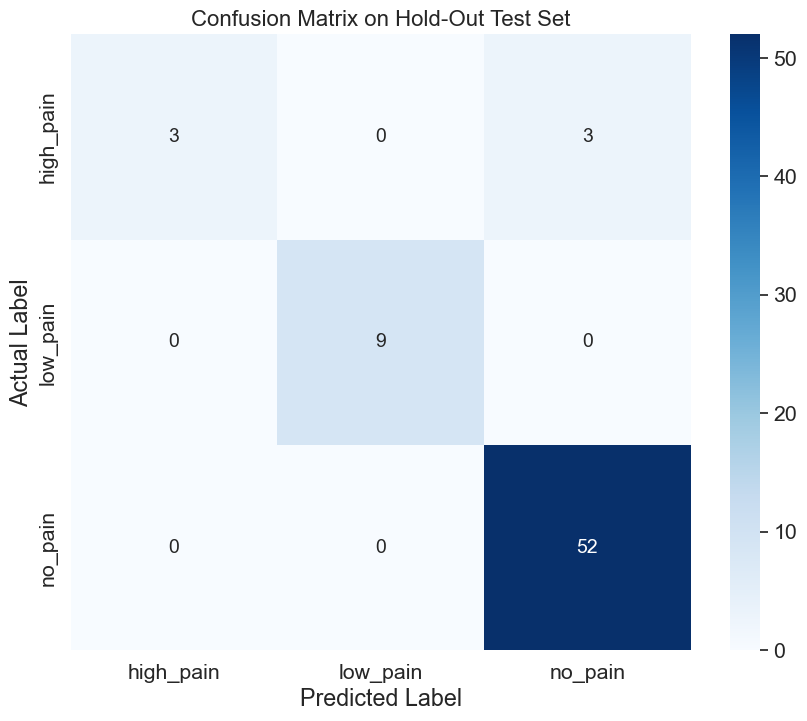

In [74]:
print("--- Preparing hold-out test set for final evaluation ---")

# --- 1. Define feature indices (must match the preprocessor) ---
spiky_indices_orig = list(range(13, 26)) 
normal_indices_orig = list(range(13)) + list(range(26, 30)) + [34] 
categorical_indices_orig = list(range(30, 34)) + [35]
continuous_indices_orig_all = normal_indices_orig + spiky_indices_orig

# --- 2. Re-order test data columns to match training ---
X_test_reordered = np.concatenate([
    X_test[:, :, continuous_indices_orig_all],
    X_test[:, :, categorical_indices_orig]], axis=2)

# --- 3. Use the same preprocessor that was fitted on the full training data ---
# (The 'preprocessor_final' object from the previous cell is used here)
ns_test, ts_test, f_test = X_test_reordered.shape
X_test_scaled = preprocessor_final.transform(X_test_reordered.reshape(ns_test * ts_test, f_test)).reshape(ns_test, ts_test, f_test)

# --- 4. Create sliding windows for the test set ---
X_test_w, _, test_window_indices = create_sliding_windows(X_test_scaled, y=y_test, window_size=FINAL_CONFIG['window_size'], stride=FINAL_CONFIG['stride'])
test_loader = make_loader(TensorDataset(torch.from_numpy(X_test_w).float()), FINAL_CONFIG['batch_size'], False, False)

all_fold_test_probabilities = []
print("\n--- Generating predictions on the hold-out test set ---")
for fold in range(TOTAL_FOLDS):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    print(f"Loading model {fold+1}/{TOTAL_FOLDS} from {model_path}...")
    model_fold = RecurrentClassifier(**model_config_final, num_classes=N_CLASSES).to(device)
    model_fold.load_state_dict(torch.load(model_path, map_location=device))
    model_fold.eval()
    
    fold_test_preds = []
    with torch.no_grad():
        for (inputs,) in test_loader:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                probs = torch.softmax(model_fold(inputs.to(device)), dim=1)
                fold_test_preds.append(probs.cpu().numpy())
    all_fold_test_probabilities.append(np.concatenate(fold_test_preds))

# --- 5. Aggregate predictions and evaluate ---
mean_test_probabilities = np.mean(all_fold_test_probabilities, axis=0)
df_test_probs = pd.DataFrame(mean_test_probabilities, columns=[f"prob_{i}" for i in range(N_CLASSES)])
df_test_probs['original_index'] = test_window_indices
agg_test_probs = df_test_probs.groupby('original_index')[[f"prob_{i}" for i in range(N_CLASSES)]].mean().values
final_test_predictions = np.argmax(agg_test_probs, axis=1)

# Get the true labels for the original samples that had windows created
true_test_labels = y_test[np.unique(test_window_indices)]

print("\n--- Final Ensemble Performance on Hold-Out Test Set ---")
final_f1_score = f1_score(true_test_labels, final_test_predictions, average='weighted')
print(f"\n>>> Weighted F1-Score: {final_f1_score:.4f} <<<")

# Classification Report
class_names = le.classes_
report = classification_report(true_test_labels, final_test_predictions, target_names=class_names)
print("\nClassification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(true_test_labels, final_test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Hold-Out Test Set', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()